In [1]:
import numpy as np
import tensorflow as tf
import time
from tqdm import tqdm
import os
import sys

sys.path.append(os.path.expanduser(os.environ['RECSYS_IM_HOME']))
SEED = 42

/Users/YuLong/miniconda3/envs/py_37_ds/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/YuLong/miniconda3/envs/py_37_ds/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/YuLong/miniconda3/envs/py_37_ds/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/YuLong/miniconda3/envs/py_3

# Data

In [2]:
from tensorflow.examples.tutorials.mnist import input_data
# from sklearn.datasets import fetch_mldata
from sklearn.datasets import fetch_openml
from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, accuracy_score

print('-----END IMPORT MESSAGE------ \n\n\n')

# dataset = fetch_openml("mnist_784")
mnist = input_data.read_data_sets("MNIST_data/")

mnist_images = mnist.train.images
mnist_labels = mnist.train.labels

n_three, n_five = sum(mnist_labels==3), sum(mnist_labels==5)

X_all = np.vstack([
    mnist_images[mnist_labels==3,:],
    mnist_images[mnist_labels==5,:]
])

y_all = np.array([1] * n_three + [0] * n_five)
# make it more sparse
X_all = X_all * (np.random.uniform(0, 1, X_all.shape) > 0.8)


print('Dataset shape: {}'.format(X_all.shape))
print('Non-zeros rate: {:.05f}'.format(np.mean(X_all != 0)))
print('Classes balance: {:.03f} / {:.03f}'.format(np.mean(y_all==0), np.mean(y_all==1)))

X_tr, X_te, y_tr, y_te = train_test_split(X_all, y_all, random_state=SEED, test_size=0.3)

-----END IMPORT MESSAGE------ 



Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Dataset shape: (10625, 784)
Non-zeros rate: 0.04036
Classes balance: 0.469 / 0.531


# Models

In [3]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from time import time

benchmark_dict = {'model' : [],
                  'acc' : [],
                  'training time(s)' : [],
                  'inference time(ms)' : []}
N_INFERENCE = 50
for model in [
                LogisticRegression(random_state=SEED),
                SVC(random_state=SEED, kernel='poly', degree=2),
                RandomForestClassifier(n_jobs=-1, n_estimators=200, random_state=SEED),
                LGBMClassifier(n_estimators=200, random_state=SEED, n_jobs=-1)
            ]:
    # training parts
    train_start = time()
    model.fit(X_tr, y_tr)
    # profiling
    training_time = time() - train_start
    model_name = type(model).__name__
    predictions = model.predict(X_te)
    acc = accuracy_score(y_te, predictions)
    # log the performance
    benchmark_dict['model'].append(model_name)
    benchmark_dict['acc'].append(acc)
    benchmark_dict['training time(s)'].append(training_time)
    

    # inference part
    inference_time_list = []
    for _ in range(N_INFERENCE):
        inference_start = time()
        model.predict(X_te[0, :].reshape(1, -1))
        inference_time = (time() - inference_start) * 1000
        inference_time_list.append(inference_time_list)
    benchmark_dict['inference time(ms)'].append(np.mean(inference_time))
    
    print('model: {}'.format(model.__str__()))
    print('accuracy: {}'.format(acc))
    print()

/Users/YuLong/miniconda3/envs/py_37_ds/lib/python3.7/site-packages/lightgbm/__init__.py:48: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.3) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


model: LogisticRegression(random_state=42)
accuracy: 0.8732747804265998

model: SVC(degree=2, kernel='poly', random_state=42)
accuracy: 0.8820577164366374

model: RandomForestClassifier(n_estimators=200, n_jobs=-1, random_state=42)
accuracy: 0.8786072772898369

model: LGBMClassifier(n_estimators=200, random_state=42)
accuracy: 0.8870765370138017



# Dense

In [5]:
from tffm.tffm import TFFMClassifier

for order in [2, 3]:
    model = TFFMClassifier(
        order=order, 
        rank=100, 
        optimizer=tf.train.AdamOptimizer(learning_rate=0.001), 
        n_epochs=50, 
        batch_size=1024,
        init_std=0.001,
        reg=0.01,
        input_type='dense',
        seed=SEED
    )
    # training part
    # profiling
    start = time()
    model.fit(X_tr, y_tr, show_progress=True)
    training_time = time() - start
    predictions = model.predict(X_te)
    acc = accuracy_score(y_te, predictions)
    model_name = type(model).__name__
    # log the performance
    benchmark_dict['model'].append(f'{model_name}_order_{order}_dense')
    benchmark_dict['acc'].append(acc)
    benchmark_dict['training time(s)'].append(training_time)
    # inference part
    inference_time_list = []
    for _ in range(N_INFERENCE):
        inference_start = time()
        model.predict(X_te[0, :].reshape(1, -1))
        inference_time = (time() - inference_start) * 1000
        inference_time_list.append(inference_time_list)
    benchmark_dict['inference time(ms)'].append(np.mean(inference_time))
    
    print('[order={}] accuracy: {}'.format(order, acc))
    # this will close tf.Session and free resources
    model.destroy()  







Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where





100%|██████████| 50/50 [00:04<00:00, 11.83epoch/s]
/Users/YuLong/miniconda3/envs/py_37_ds/lib/python3.7/site-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


[order=2] accuracy: 0.8814303638644918


100%|██████████| 50/50 [00:11<00:00,  4.39epoch/s]


[order=3] accuracy: 0.9153074027603513


# Sparse

In [6]:
import scipy.sparse as sp
# only CSR format supported
X_tr_sparse = sp.csr_matrix(X_tr)
X_te_sparse = sp.csr_matrix(X_te)

In [7]:
for order in [2, 3]:
    model = TFFMClassifier(
        order=order, 
        rank=100, 
        optimizer=tf.train.AdamOptimizer(learning_rate=0.001), 
        n_epochs=50, 
        batch_size=1024,
        init_std=0.001,
        reg=0.01,
        input_type='sparse',
        seed=SEED
    )
    # training part
    # profiling
    start = time()
    model.fit(X_tr_sparse, y_tr, show_progress=True)
    training_time = time() - start
    predictions = model.predict(X_te_sparse)
    acc = accuracy_score(y_te, predictions)
    model_name = type(model).__name__
    # log the performance
    benchmark_dict['model'].append(f'{model_name}_order_{order}_sparse')
    benchmark_dict['acc'].append(acc)
    benchmark_dict['training time(s)'].append(training_time)
    # inference part
    inference_time_list = []
    for _ in range(N_INFERENCE):
        inference_start = time()
        model.predict(X_te_sparse[0, :])
        inference_time = (time() - inference_start) * 1000
        inference_time_list.append(inference_time_list)
    benchmark_dict['inference time(ms)'].append(np.mean(inference_time))
    
    print('[order={}] accuracy: {}'.format(order, acc))
    # this will close tf.Session and free resources
    model.destroy()  

100%|██████████| 50/50 [00:32<00:00,  1.52epoch/s]


[order=2] accuracy: 0.8814303638644918


/Users/YuLong/miniconda3/envs/py_37_ds/lib/python3.7/site-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)
100%|██████████| 50/50 [01:03<00:00,  1.27s/epoch]


[order=3] accuracy: 0.9153074027603513


# model vs acc / training time / inference time

dict_keys(['model', 'acc', 'training time(s)', 'inference time(ms)'])


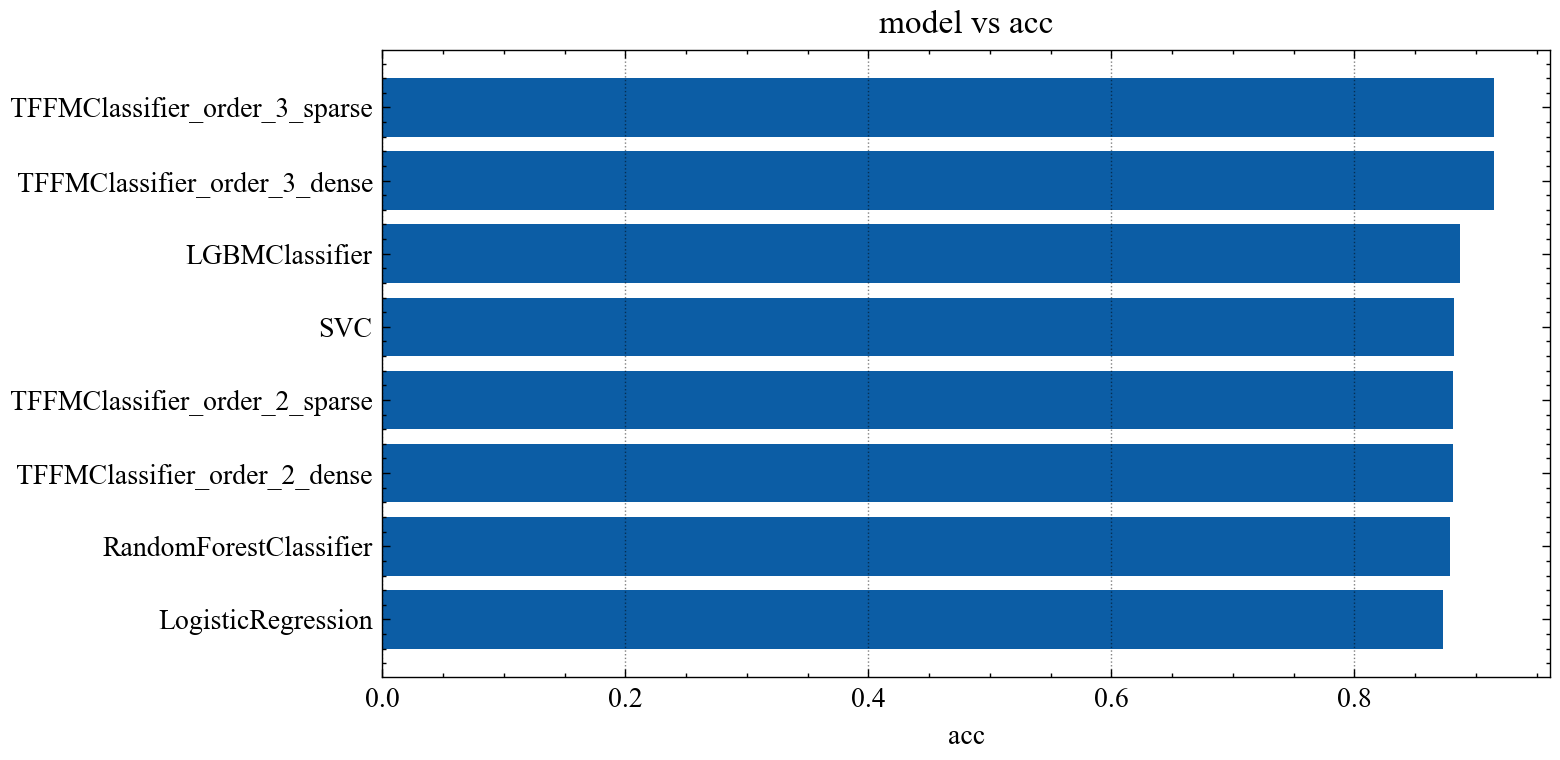

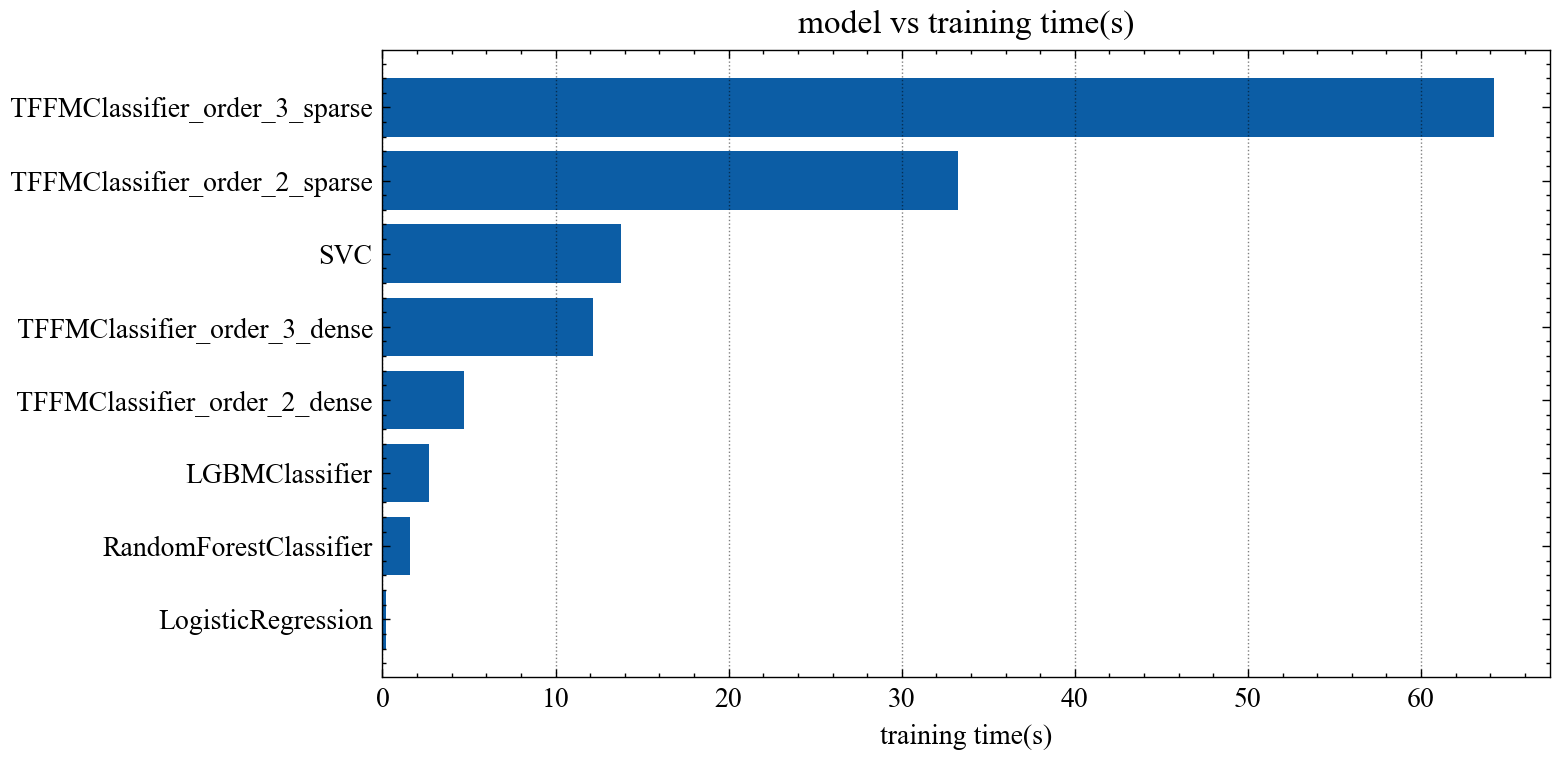

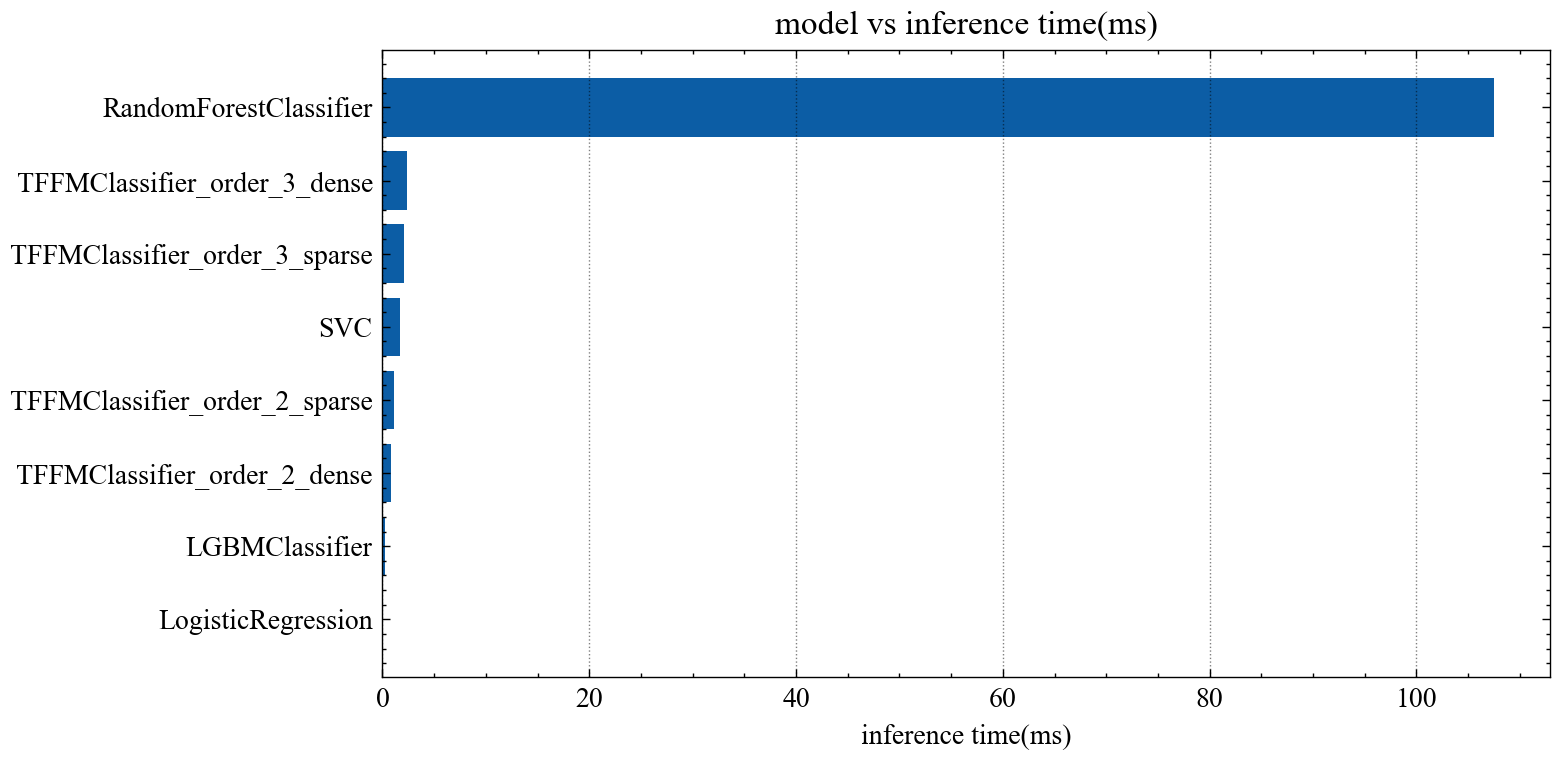

In [8]:
# plot
from matplotlib import pyplot as plt
import pandas as pd
benchmark_df = pd.DataFrame(benchmark_dict)
print(benchmark_dict.keys())

def plot_barh(df, x, y, is_saved = False, save_path='.'):
    sorted_df = df.sort_values(y,ascending=True)
    with plt.style.context(['science', 'grid', 'no-latex']):
        fig, ax = plt.subplots(figsize=(8,4),dpi=200)
        fig_title_name = f"{x} vs {y}"
        plt.barh(sorted_df[f'{x}'], sorted_df[f'{y}'])
        plt.xlabel(y)
        # No need, self document by category
        # plt.ylabel
        plt.title(fig_title_name)
        plt.grid(axis='y')
        plt.tight_layout()
        if is_saved:
            plt.savefig(os.path.join(save_path,f'{fig_title_name}.png'))
        plt.show()

plot_barh(benchmark_df, x='model', y='acc',is_saved=False)
plot_barh(benchmark_df, x='model', y='training time(s)',is_saved=False)
plot_barh(benchmark_df, x='model', y='inference time(ms)',is_saved=False)

In [9]:
benchmark_df

,model,acc,training time(s),inference time(ms)
0,LogisticRegression,0.873275,0.226785,0.070810
1,SVC,0.882058,13.757286,1.660109
2,RandomForestClassifier,0.878607,1.602828,107.545137
3,LGBMClassifier,0.887077,2.693413,0.235081
4,TFFMClassifier_order_2_dense,0.881430,4.699206,0.794888
5,TFFMClassifier_order_3_dense,0.915307,12.170004,2.353907
6,TFFMClassifier_order_2_sparse,0.881430,33.253480,1.084805
7,TFFMClassifier_order_3_sparse,0.915307,64.237141,2.076149


# Inference Time Complexity

* x axis - n features
* y axis - inference time(ms) (per sample)
* color - dense, sparse

In [10]:
n_features = X_all.shape[1]
used_features = range(100, 1000, 100)
N_INFERENCE = 50
inference_complexity_dict = {'input_type' : [], 'mean' : [], 'std' : []}


for input_type in ['dense','sparse']:
    elapsed_mean = []
    elapsed_std = []
    for cur_n_feats in tqdm(used_features):
        active_features = np.random.choice(range(n_features), size=cur_n_feats)
        model = TFFMClassifier(
                    order=2, 
                    rank=100,
                    optimizer=tf.train.AdamOptimizer(learning_rate=0.001), 
                    n_epochs=1, 
                    batch_size=-1,
                    init_std=0.01,
                    input_type=input_type
        )
        # training
        if input_type == 'dense':
            x = X_all[:, active_features]
            x_onlyone = X_all[0, active_features].reshape(1, -1)
        else:
            x = sp.csr_matrix(X_all[:, active_features])
            x_onlyone = sp.csr_matrix(X_all[0, active_features])
        y = y_all
        model.fit(x, y)
        # model inference warm start
        for _ in range(5):
            model.predict(x_onlyone)
        # inference part
        time_observation = []
        for _ in range(N_INFERENCE):
            start_time = time()
            model.predict(x_onlyone)
            end_time = time()
            infernece_time = (end_time - start_time) * 1000
            time_observation.append(infernece_time)
        model.destroy()
        elapsed_mean.append(np.mean(time_observation))
        elapsed_std.append(np.std(time_observation))
    inference_complexity_dict['input_type'].append(input_type)
    inference_complexity_dict['mean'].append(elapsed_mean)
    inference_complexity_dict['std'].append(elapsed_std)
    

100%|██████████| 9/9 [00:16<00:00,  1.78s/it]


In [11]:
# shows mean and std
complexity_df = pd.DataFrame(inference_complexity_dict).set_index('input_type')
complexity_df

,mean,std
input_type,,
dense,"[0.36046504974365234, 0.43300628662109375, 0.4...","[0.04230392875442891, 0.01673741625366874, 0.0..."
sparse,"[0.678706169128418, 0.6539583206176758, 0.8170...","[0.05503490484719651, 0.02398330927721829, 0.0..."


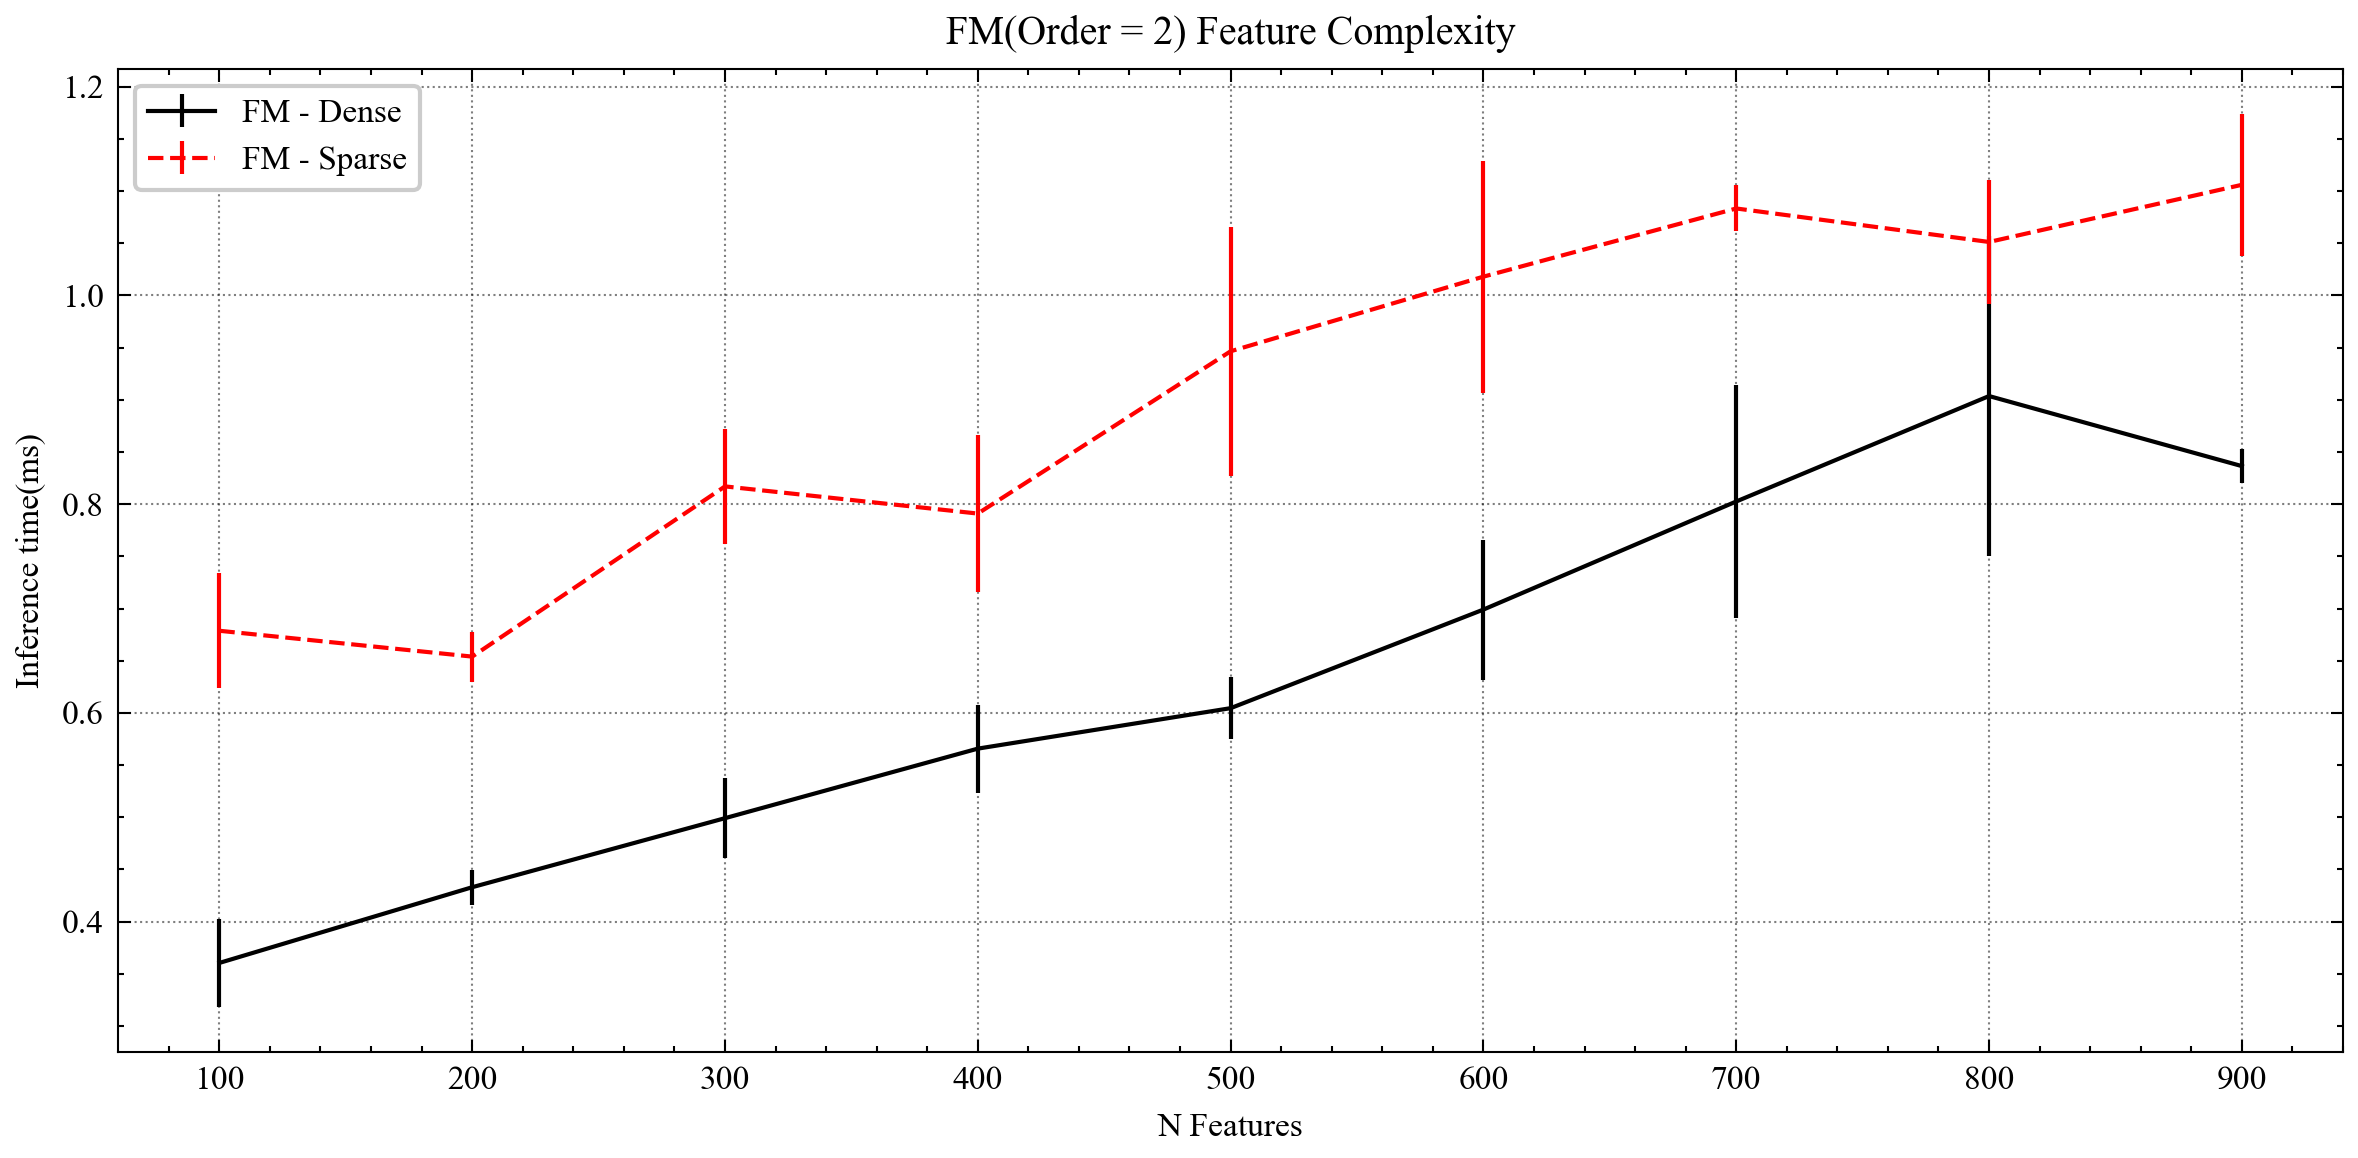

In [12]:
with plt.style.context(['science','ieee','grid', 'no-latex']):
    fig, ax = plt.subplots(figsize=(8,4),dpi=300)
    plt.errorbar(used_features, complexity_df.loc['dense','mean'],
                 yerr=complexity_df.loc['dense','std'], label='FM - Dense')

    plt.errorbar(used_features, complexity_df.loc['sparse','mean'],
             yerr=complexity_df.loc['sparse','std'], label='FM - Sparse')
    
    plt.title('FM(Order = 2) Feature Complexity')
    plt.xlabel('N Features')
    plt.ylabel('Inference time(ms)')
    plt.legend(loc='best')
    plt.tight_layout()
    plt.savefig('fm_feature_complexity.png')
    plt.show()